# Infection rate vs positive opinion fraction for different system size and timescale (qVoterPerStep)


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 100
nSaveSteps: 1
nRuns: 5
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: true
comorbidities: false
qVoterParameters:
  p: 0.5 # 0.1
  q: 6
epidemicLayerParameters:
  beta: 0.1
  zeta: 0.0
  alpha: 0.0
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 0.9
proPisFraction: 0.0
pisVaccinationCorrelation: 0.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/fig2_infection_rate_vs_posFrac_timescale
firstParameterRange:
  start: 0.0
  end: 0.5
  count: 0
  vals: [0.01, 0.05, 0.1, 0.5]
  type: beta
secondParameterRange:
  start: 0.0
  end: 1.0
  count: 21
  vals: null
  type: positiveOpinionFraction
thirdParameterRange: null
  # start: 0
  # end: 0
  # count: 0
  # vals: [1, 2, 5, 10, 20]
  # type: nQVoterPerStep
linksRemoval: false
nQVoterPerStep: 1
vaccinationFraction: 0.0
```

In [31]:
def load_df(prefix, beta, folder, fracPos, qvotersteps, p, nagents=10000, q=6, nsteps=100, nruns=5):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_INFECTED=0.1_QVOTER=p={p}_q={q}_PIS=0.0_EPIDEMIC=beta={beta}_zeta=0,00_alpha=0,00_gamma=0,50_mu=0,90_kappa=0,10_QVOTERSTEPS={qvotersteps}_NRUN={n}.tsv"
        
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    return dfs1


betas = ['0,01', '0,05', '0,10', '0,50']
betas_float = [float(b.replace(',', '.')) for b in betas]

ps = ['0,01', '0,50']

qVoterSteps = [1, 2, 5, 10, 20]

fPs = [x / 100 for x in range(101)][::5]

print('ps: ', ps)
print('Betas: ', betas, len(betas))
print('pos opnion fracs: ', fPs, len(fPs))

ps:  ['0,01', '0,50']
Betas:  ['0,01', '0,05', '0,10', '0,50'] 4
pos opnion fracs:  [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0] 21


In [32]:
def load_dfs(beta, p, qVoterSteps=qVoterSteps, fPs=fPs, 
             path='fig2_infection_rate_vs_posFrac_timescale', prefix='off'):
    """
    { qVoterSteps: list of dataframes, one per `positiveOpinionFraction` value }
    
    e.g.

    {2: [pd.DataFrame(beta=0.00), pd.DataFrame(beta=0.01), ...]}
    """
    xs = {}
    for qVoterStep in tqdm(qVoterSteps):
        xs_per_qVoterStep = []
        for posFrac in fPs:
            df1 = load_df(prefix, beta, path, posFrac, qVoterStep, p)
            xs_per_qVoterStep.append(df1)
        xs[qVoterStep] = xs_per_qVoterStep
    return xs


def load_all_dfs(betas, p):
    """
    { qvoterstep: {beta: list of dataframes}, ... }
    """
    df_per_p = {}
    for beta in betas:
        df_per_p[beta] = load_dfs(beta, p)
    return df_per_p 

In [33]:
%%time

dfs_betas_0_01 = load_all_dfs(betas, '0,01')
dfs_betas_0_50 = load_all_dfs(betas, '0,50')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 35.7 s, sys: 295 ms, total: 36 s
Wall time: 36 s


In [34]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


colors = ['red', 'green', 'blue', 'purple', 'brown']
colors = ['xkcd:' + c for c in colors]
markers = ['o', 'v', '^', 'D', 's']

def max_infection_rate(df):
    return df['infectedRate'].max()

def max_quarantine_rate(df):
    return df['quarantinedRate'].max()

def last_opinion(df):
    return df['meanOpinion'].to_numpy()[-1]

def last_recovered_rate(df):
    return df['recoveredRate'].to_numpy()[-1]

def time_max_infection(df):
    return df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]


def plot_max_infection_peak_vs_beta_per_posFrac(dfs, fPs=fPs, markers=markers, colors=colors,
                                                fun=max_infection_rate, add_legend=False):
    i = 0
    markers_legend = []
    for qVoterStep, df in dfs.items():
        peaks = [fun(x) for x in df]
        plt.plot(fPs, peaks, 'o--', label=f'Qstep={qVoterStep}', linewidth=1, color=colors[i], 
                 marker=markers[i], mfc='none', markersize=7)
        i += 1
    
    plt.xlabel(r'pos opinion frac')
    plt.ylabel(r'$I_{max}$') # max infection rate
    if add_legend:
        plt.legend()

### p = 0.01

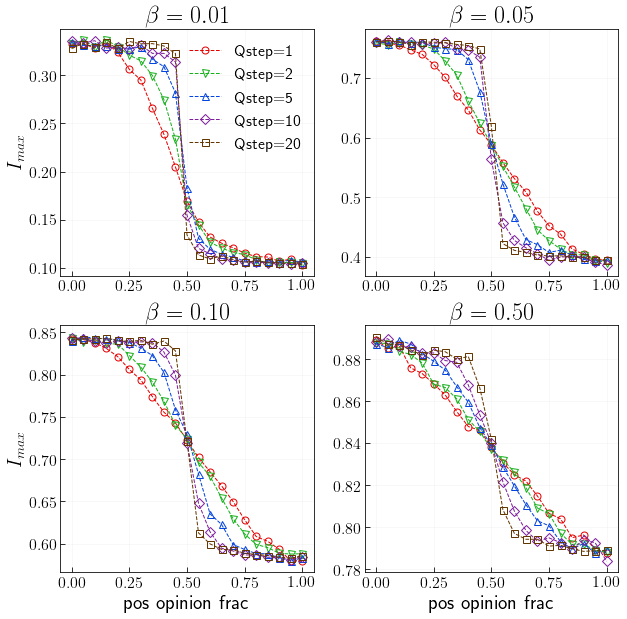

In [36]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_01['0,01'], add_legend=True)
plt.xlabel('')
plt.title(r'$\beta=0.01$')

plt.subplot(2, 2, 2)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_01['0,05'])
plt.xlabel('')
plt.ylabel('')
plt.title(r'$\beta=0.05$')

plt.subplot(2, 2, 3)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_01['0,10'])
plt.title(r'$\beta=0.10$')

plt.subplot(2, 2, 4)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_01['0,50'])
plt.ylabel('')
plt.title(r'$\beta=0.50$')

plt.show()

### p = 0.5

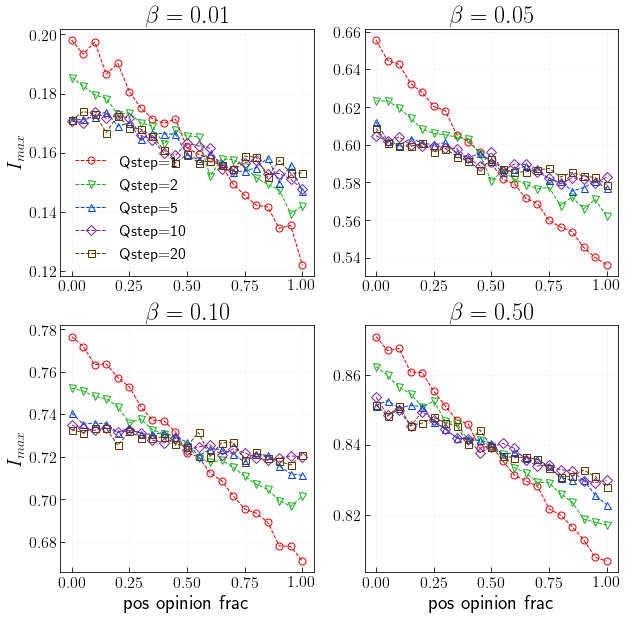

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_50['0,01'], add_legend=True)
plt.xlabel('')
plt.title(r'$\beta=0.01$')

plt.subplot(2, 2, 2)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_50['0,05'])
plt.xlabel('')
plt.ylabel('')
plt.title(r'$\beta=0.05$')

plt.subplot(2, 2, 3)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_50['0,10'])
plt.title(r'$\beta=0.10$')

plt.subplot(2, 2, 4)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas_0_50['0,50'])
plt.ylabel('')
plt.title(r'$\beta=0.50$')

plt.show()

In [38]:
def plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs, tmp_fPs, markers=markers, colors=colors,
                                                    fun=max_infection_rate, add_legend=False, max_xlim=50):
    i = 0
    markers_legend = []
    plt.figure(figsize=(12, 12))
    for fP in tmp_fPs:
        plt.subplot(3, 3, i + 1)
        j = 0
        for qVoterStep, df in dfs.items():
            tmp = df[fPs.index(fP)]
            plt.plot(tmp.step, tmp.infectedRate, 'o--', label=f'Qsteps={qVoterStep}', linewidth=1, 
                     color=colors[j], marker=markers[j], mfc='none', markersize=6)
            j += 1
        i += 1
        if i == 1 or i == 4 or i == 7:
            plt.ylabel(r'$I$')
        if i in [7, 8, 9]:
            plt.xlabel(r'$t$')
        
        plt.xlim(-1, max_xlim)
        plt.title('posFrac={}'.format(fP))
    if add_legend:
        plt.legend(fontsize=14)

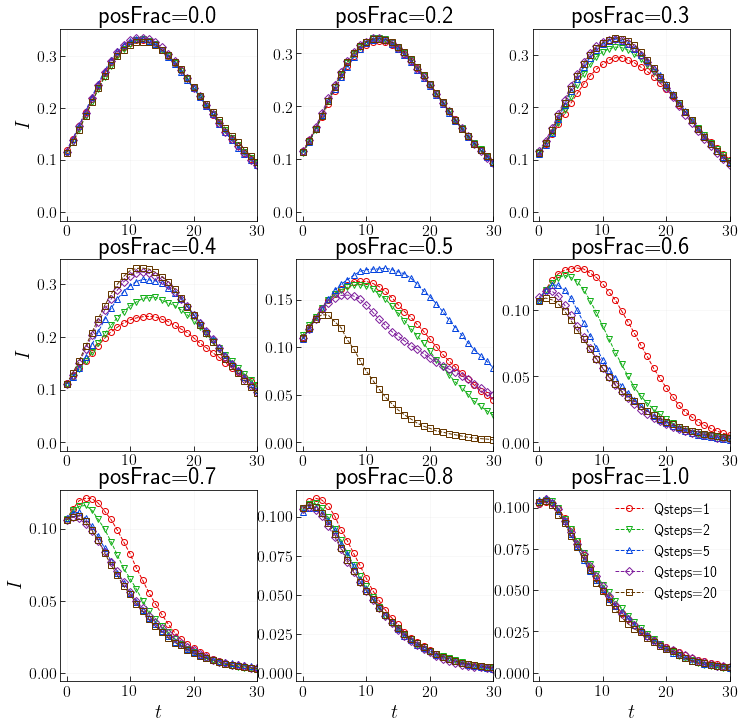

In [41]:
tmp_fPs = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs_betas_0_01['0,01'], tmp_fPs, add_legend=True, max_xlim=30)

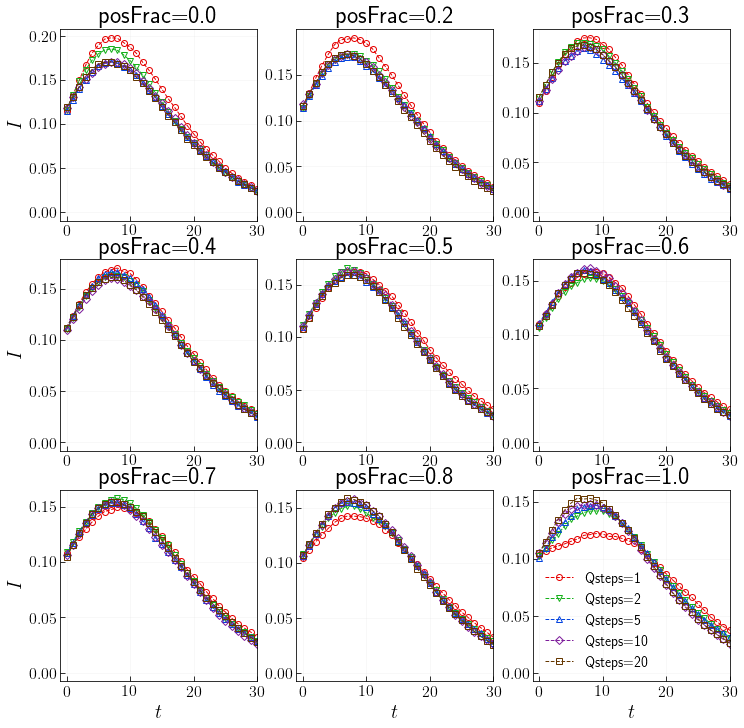

In [42]:
tmp_fPs = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs_betas_0_50['0,01'], tmp_fPs, add_legend=True, max_xlim=30)

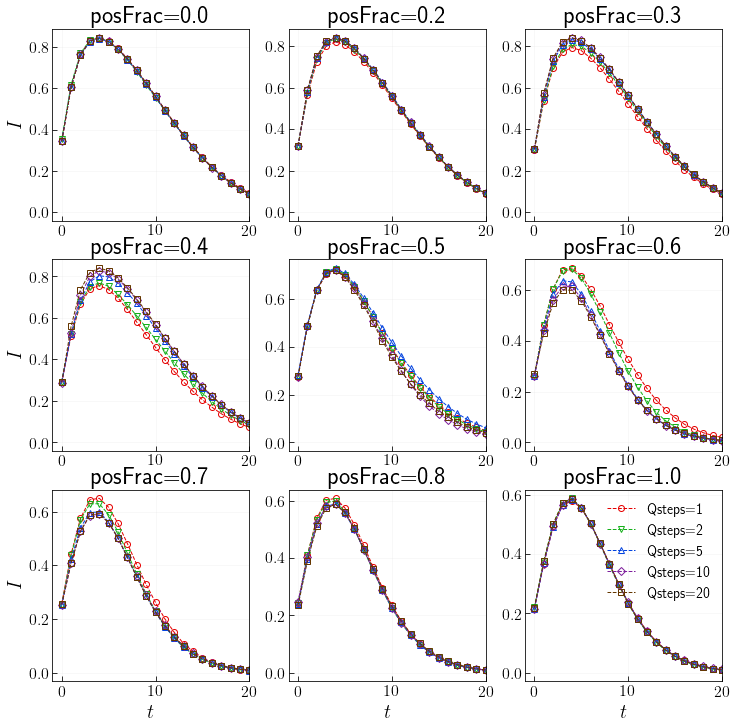

In [43]:
tmp_fPs = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs_betas_0_01['0,10'], tmp_fPs, add_legend=True, max_xlim=20)

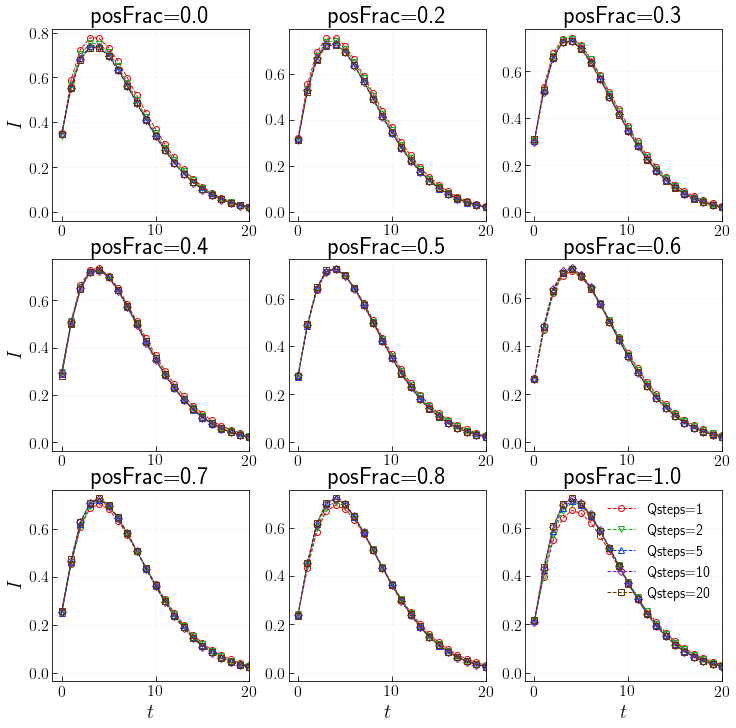

In [44]:
tmp_fPs = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs_betas_0_50['0,10'], tmp_fPs, add_legend=True, max_xlim=20)